In [1]:
import numpy as np




!unzip./ Data / orange_small_test.data.zip
!unzip./ Data / orange_small_train.data.zip

In [2]:
import pandas as pd

In [3]:
X_train = pd.read_csv('./Data/orange_small_train.data', sep='\t')
X_test = pd.read_csv('./Data/orange_small_test.data', sep='\t')
y_train_churn = pd.read_csv('./Data/orange_small_train_churn.labels.txt', header=None)
y_train_apt = pd.read_csv('./Data/orange_small_train_appetency.labels', header=None)
y_train_upsell = pd.read_csv('./Data/orange_small_train_upselling.labels', header=None)

In [4]:
X_train.shape, X_test.shape

((50000, 230), (50000, 230))

In [5]:
y_train_apt.shape, y_train_churn.shape, y_train_upsell.shape

((50000, 1), (50000, 1), (50000, 1))

In [6]:
y_train_apt.value_counts(normalize=True), y_train_churn.value_counts(normalize=True), y_train_upsell.value_counts(
    normalize=True)

(-1    0.9822
  1    0.0178
 dtype: float64,
 -1    0.92656
  1    0.07344
 dtype: float64,
 -1    0.92636
  1    0.07364
 dtype: float64)

In [7]:
# dropping any column with missing value

# collect minimum no of records to be present value for data
# using data with high percentage of missing records makes bad training set and will induce a high variance in the model predictions
missing_perc = 20
min_count = int(((100 - missing_perc) / 100) * X_train.shape[0] + 1)
min_count

40001

### Feature engineering

In [8]:
#drop all missing and only continous variable
prefered_uniques = 10
# create a list of numeric values and less than prefered uniques categorical columns
fe_unique_columns = list(X_train.select_dtypes(include='number').columns) + list(
    (X_train.select_dtypes(include='object').nunique() < prefered_uniques).index[
        X_train.select_dtypes(include='object').nunique() < prefered_uniques])
# collect only numeric features
X_train_all_missing_drop_continous = X_train.dropna(axis=1, thresh=min_count).dropna(axis=0).select_dtypes(
    include=['number'])  #.agg(['nunique','count'])
numeric_col_after_drop = X_train_all_missing_drop_continous.columns
# create X_train with categorical variables with less than 10 uniques
X_train_all_missing_dropped_prefered_unique_cat = X_train[fe_unique_columns].dropna(axis=1, thresh=min_count).dropna(
    axis=0)
feature_prefered_columns = list(X_train_all_missing_dropped_prefered_unique_cat.columns)
# creating dummy variables for the data with  categorical variables
X_train_encoded = pd.get_dummies(X_train_all_missing_dropped_prefered_unique_cat, drop_first=True)
X_train_numeric = X_train_all_missing_drop_continous
del X_train_all_missing_drop_continous
# selecting X_test with the appropriate predictors for numeric predictors and selected unique threshold for category inclusion in predictors
X_test_numeric = X_test[numeric_col_after_drop]
X_test_encoded = pd.get_dummies(X_test[feature_prefered_columns], drop_first=True)[X_train_encoded.columns]


In [9]:
X_train_encoded.shape, X_train_numeric.shape, X_test_encoded.shape

((36827, 68), (36730, 38), (50000, 68))

In [10]:
# check for imbalance when only the X_train_encoded index is selected
pd.Series(y_train_apt.values[X_train_encoded.index].reshape(-1, )).value_counts(normalize=True),
pd.Series(y_train_churn.values[X_train_encoded.index].reshape(-1, )).value_counts(normalize=True),
pd.Series(y_train_upsell.values[X_train_encoded.index].reshape(-1, )).value_counts(normalize=True)


-1    0.919325
 1    0.080675
dtype: float64

In [11]:
# check for imbalance when only the X_train_numeric index is selected
pd.Series(y_train_apt.values[X_train_numeric.index].reshape(-1, )).value_counts(normalize=True),
pd.Series(y_train_churn.values[X_train_numeric.index].reshape(-1, )).value_counts(normalize=True),
pd.Series(y_train_upsell.values[X_train_numeric.index].reshape(-1, )).value_counts(normalize=True)


-1    0.919357
 1    0.080643
dtype: float64

In [12]:
y_train_apt_numeric = y_train_apt.values[X_train_numeric.index]
y_train_apt_encoded = y_train_apt.values[X_train_encoded.index]
y_train_churn_numeric = y_train_churn.values[X_train_numeric.index]
y_train_churn_encoded = y_train_churn.values[X_train_encoded.index]
y_train_upsell_numeric = y_train_upsell.values[X_train_numeric.index]
y_train_upsell_encoded = y_train_upsell.values[X_train_encoded.index]

## Churn model

In [13]:
from sklearn.model_selection import  train_test_split
X_train_churn_numeric,X_val_churn_numeric,y_train_churn_numeric,y_val_churn_numeric = train_test_split(X_train_numeric,y_train_churn_numeric,test_size=0.2,stratify=y_train_churn_numeric)

In [14]:
X_train_churn_numeric.shape,X_val_churn_numeric.shape,y_train_churn_numeric.shape,y_val_churn_numeric.shape

((29384, 38), (7346, 38), (29384, 1), (7346, 1))

ls_y_trains_apt = [y_train_apt_numeric, y_train_apt_encoded]
ls_y_trains_churn = [y_train_churn_numeric, y_train_churn_encoded]
ls_y_trains_upsell = [y_train_upsell_numeric, y_train_upsell_encoded]
all_y_trains = [ls_y_trains_apt, ls_y_trains_churn, ls_y_trains_upsell]
ls_X_trains = [X_train_numeric, X_train_encoded]
ls_X_test = [X_test_numeric, X_test_encoded]


## Gradient Boosting Classifier

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators": [5,50,100],
    "max_depth": [1, 3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 1, 10, 100]
}

In [25]:
%%time
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(gbc,parameters,cv=5,scoring='roc_auc',n_jobs=-1)


CPU times: user 49 µs, sys: 23 µs, total: 72 µs
Wall time: 88 µs


In [75]:
%%time
cv_results = cv.fit(X_train_churn_numeric.values,y_train_churn_numeric.ravel())

CPU times: user 7.28 s, sys: 434 ms, total: 7.71 s
Wall time: 3min 35s


In [76]:
print("Best: %f using %s" % (cv_results.best_score_, cv_results.best_params_))

Best: 0.634278 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [77]:
predictions = cv.predict(X_val_churn_numeric)

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [78]:
from sklearn.metrics import accuracy_score,roc_auc_score

In [79]:
print(f"{accuracy_score(y_val_churn_numeric,predictions)}")
print(f"{roc_auc_score(y_val_churn_numeric,predictions)}")

0.929213177239314
0.4998535442296426


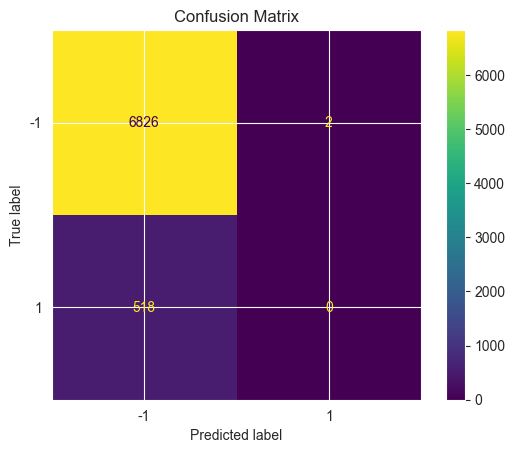

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val_churn_numeric, predictions, labels=cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cv.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [81]:
cm

array([[6826,    2],
       [ 518,    0]])

# trying out sample weights

In [82]:
sample_weights = np.zeros(len(y_train_churn_numeric)).reshape(-1,1)
sample_weights[y_train_churn_numeric == -1] = 0.5
sample_weights[y_train_churn_numeric == 1] = 9.1

In [83]:
sample_weights.shape

(29384, 1)

In [84]:
cv_results = cv.fit(X_train_churn_numeric.values,y_train_churn_numeric.ravel(),sample_weight = sample_weights.reshape(-1,))

In [85]:
print("Best: %f using %s" % (cv_results.best_score_, cv_results.best_params_))

Best: 0.630053 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [86]:
predictions = cv.predict(X_val_churn_numeric)

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [87]:
print(f"{accuracy_score(y_val_churn_numeric,predictions)}")
print(f"{roc_auc_score(y_val_churn_numeric,predictions)}")

0.3773482167165805
0.5696091836250008


In [88]:
# we observe improvement in the validation roc_auc score but the accuracy score is fairly dropped

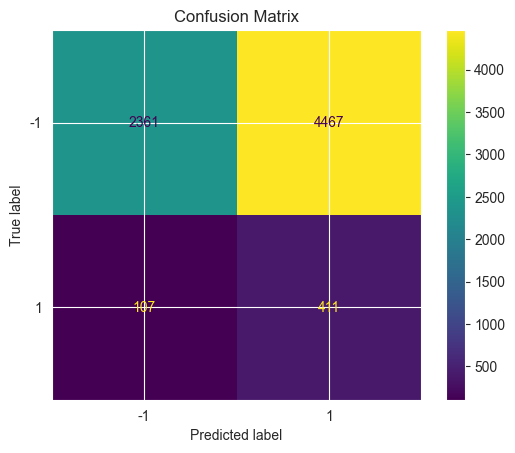

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val_churn_numeric, predictions, labels=cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cv.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [90]:
cm

array([[2361, 4467],
       [ 107,  411]])

In [ ]:
# the drawback here is even the non churn values got classified as churn, this is tradeoff if we want higher accuracy on getting all possible churns; Spending an extra amount to promote retention is better than loosing any and way more expensive to gain new ones

### SMOTE , UPSAMPLING

In [92]:
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

In [94]:
sm = SMOTE(random_state=2)
X_train_res_numerix, y_train_res_numerix = sm.fit_resample(X_train_churn_numeric,y_train_churn_numeric)

In [112]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators": [5,50],
    "max_depth": [1, 3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 1, 10]
}

In [113]:
%%time
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(gbc,parameters,cv=5,scoring='roc_auc',n_jobs=-1)


CPU times: user 26 µs, sys: 25 µs, total: 51 µs
Wall time: 67.2 µs


In [125]:
X_train_res_numerix.shape,X_train_churn_numeric.shape

((54626, 38), (29384, 38))

In [114]:
%%time
cv_results = cv.fit(X_train_res_numerix.values,y_train_res_numerix.ravel())

CPU times: user 1min 7s, sys: 569 ms, total: 1min 7s
Wall time: 9min 58s


In [115]:
cv_results

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50]},
             scoring='roc_auc')

In [116]:
print("Best: %f using %s" % (cv_results.best_score_, cv_results.best_params_))

Best: 0.973416 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}


In [120]:
predictions = cv.predict(X_val_churn_numeric)

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [121]:
print(f"{accuracy_score(y_val_churn_numeric,predictions)}")
print(f"{roc_auc_score(y_val_churn_numeric,predictions)}")

0.929213177239314
0.4998535442296426


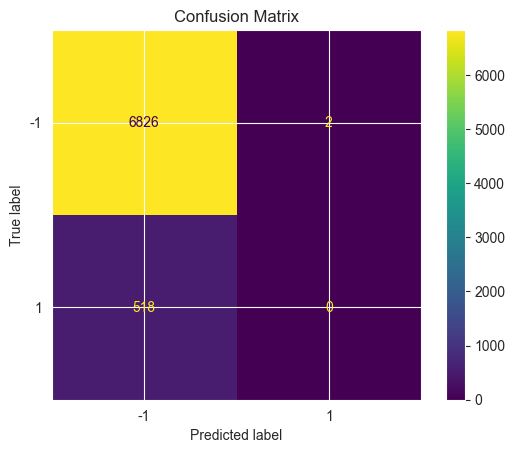

In [122]:
cm = confusion_matrix(y_val_churn_numeric, predictions, labels=cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cv.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [1]:
cm

NameError: name 'cm' is not defined